In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
stock_list = pd.read_csv('../data/stock_list.csv')
stock_price = pd.read_csv('../data/stock_price.csv')
stock_fin = pd.read_csv('../data/stock_fin.csv', index_col='base_date')
stock_labels = pd.read_csv('../data/stock_labels.csv')

# Datetimeに変換
stock_fin.index = pd.to_datetime(stock_fin.index)

### 特徴量の生成
<テクニカル指標>  
* 移動平均乖離率(5日、25日、75日)
* ヒストリカルボラティリティ(5日, 10日, 25日, 50日, 75日, 100日) ← 10日, 50日, 100日を追加  
* 過去n日間の最高値に対する終値・高値（安値)との乖離率(n=5, 10, 20)  
* キリ番との乖離率(9,999円未満の株価は100円台を基準、 10,000円は1000円台を基準)  
* RSI
* H-L_C: 株価に対する1日当たりの値幅
* MA20_H-LC: H-L_Cの移動平均(20日)
* 各ヒストリカルボラティリティの移動平均(20日)

今回の予測対象は最大値と最小値であるため。高値と安値に関する指標あったほうがよさそう。  
実際、株価は過去の株価の高値や安値をサポートラインとすることが多い。  
キリ番(キリが良い番号。100円とか)もサポートラインになることが多い。  
  
<ファンダメンタル指標>
* 売上高営業利益率, 売上高経常利益率, 売上高当期純利益率 
* 前期比(成長率)  
* 来期予想成長率  
* 自己資本比率
* ROE(当期純利益÷自己資本)
* ROA
* PER, PBRは用意されたデータセットの発行済み株式数では未来情報のため利用しない
* キャッシュフローの正負(四半期データは欠損値となっている。それらはゼロにする)
* 配当利回り  
  欠損値が少ない一株当たりの四半期配当金を利用する。欠損値は、データの開始時点から1年が多く見られるため、問題なさそう。
* 決算種別:Result_FinancialStatement ReportType
  季節効果を期待して組み込んでみる

 
 <価格・その他>
* 出来高:EndOfDayQuote Volume  
* 業種区分:17 Sector(Code)

※価格情報の利用を避けるために率に変換するなどして銘柄間のスケールを統一する。  
※カテゴリデータはone-hotベクトル化  
※基準化は業種区分ごとでの平均ですべきかもしれないが今回は時間の都合上、諦める


In [3]:
from decimal import Decimal, ROUND_HALF_UP

def calc_MADR(close:pd.core.series.Series, days:int) -> np.ndarray:
    '''移動平均乖離率を計算する'''
    MA = close.rolling(days).mean()
    MADR = ((close - MA) / MA).replace([np.inf, -np.inf], 0)
    return MADR.values

def calc_MXDR(high:pd.core.series.Series, days:int) -> np.ndarray:
    '''最高値乖離率を計算する'''
    MX = high.rolling(days).max()
    MXDR = ((high - MX) / MX).replace([np.inf, -np.inf], 0)
    return MXDR.values

def calc_MNDR(min_:pd.core.series.Series, days:int) -> np.ndarray:
    '''最安値乖離率を計算する'''
    MN = min_.rolling(days).min()
    MNDR = ((min_ - MN) / MN).replace([np.inf, -np.inf], 0)
    return MNDR.values

def calc_RNDR(close:int) -> int:
    '''キリ番(Round Number Divergence Rate...造語)との乖離率を計算する'''
    # 10円台, 1000円台, 10000円台ではスケールが異なる。
    # 99円までは10円を基準, 9999円までは100円を基準, 10000以上は1000円基準としてみる。
    #株価は0～93600の範囲をとりうる
    if close < 100:
        RN =int(Decimal(close).quantize(Decimal('1E1'), rounding=ROUND_HALF_UP))
    elif close < 10000:
        RN =int(Decimal(close).quantize(Decimal('1E2'), rounding=ROUND_HALF_UP))
    else:
        RN =int(Decimal(close).quantize(Decimal('1E3'), rounding=ROUND_HALF_UP))
    # 終値がキリ番の場合はゼロなり割れない為、場合分け
    if close - RN != 0:
        RNDR = (close - RN) / RN
    else:
        RNDR = 0
    return RNDR

def calc_RSI(close, day):
    '''RSIを計算する'''
    RSI = (close.diff().apply(lambda x: x if x >=0 else 0).rolling(day).sum() / close.diff().abs().rolling(day).sum()).replace([np.inf, -np.inf], 0)
    return RSI.values

def add_techniacl_data(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
    dfにテクニカル指標を追加
    '''
    df = df_target.copy()
    
    # 対数リターン(前日比)
    df["log_R"] = np.log1p(df["EndOfDayQuote ExchangeOfficialClose"]).diff()
    
    # リターン(変化率)
    df["return_5"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(5)
    df["return_25"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(25)
    df["return_75"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(75)
    
    # ヒストリカルボラティリティ
    df["HV_5"] = df['log_R'].diff().rolling(5).std()
    df["HV_10"] = df['log_R'].diff().rolling(10).std()
    df["HV_25"] = df['log_R'].diff().rolling(25).std()
    df["HV_50"] = df['log_R'].diff().rolling(50).std()
    df["HV_75"] = df['log_R'].diff().rolling(75).std()
    df["HV_100"] = df['log_R'].diff().rolling(100).std()
    
    # ヒストリカルボラティリティの移動平均
    df["MA20_HV5"] = df['HV_5'].rolling(20).mean()
    df["MA20_HV10"] = df['HV_10'].rolling(20).mean()
    df["MA20_HV25"] = df['HV_25'].rolling(20).mean()
    df["MA20_HV50"] = df['HV_50'].rolling(20).mean()
    df["MA20_HV75"] = df['HV_75'].rolling(20).mean()
    df["MA20_HV100"] = df['HV_100'].rolling(20).mean()
    
    # 移動平均乖離(Moving Average Divergence Rate)を求める
    df['MADR5'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 5)
    df['MADR25'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 25)
    df['MADR75'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 75)
    
    # 最高値との乖離
    df['MXDR5'] =  calc_MXDR(df['EndOfDayQuote High'], 5)
    df['MXDR10'] =  calc_MXDR(df['EndOfDayQuote High'], 10)
    df['MXDR20'] =  calc_MXDR(df['EndOfDayQuote High'], 20)
    
    # 最高値との乖離
    df['MNDR5'] =  calc_MNDR(df['EndOfDayQuote Low'], 5)
    df['MNDR10'] =  calc_MNDR(df['EndOfDayQuote Low'], 10)
    df['MNDR20'] =  calc_MNDR(df['EndOfDayQuote Low'], 20)
    
    # キリ番との乖離
    df['RNDR'] =  df['EndOfDayQuote ExchangeOfficialClose'].apply(calc_RNDR)
    
    # RSI
    df['RSI'] = calc_RSI(df["EndOfDayQuote ExchangeOfficialClose"], 14)
    
    # 値幅(高値-安値) / 終値: O-H_C
    df['H-L_C'] =  (df['EndOfDayQuote High'] - df['EndOfDayQuote Low']) / df['EndOfDayQuote ExchangeOfficialClose']
    df['MA20_H-L_C'] = df['H-L_C'].rolling(20).mean()
    
    # 欠損値は削除
    df.dropna(inplace=True)
    
    return df

In [4]:
def clean_base_date_index(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
    更新対応処理:修正開示が20営業日以内の場合は修正前のデータはdfから削除する。
    20日以上の場合は、修正後のデータを削除する。今回は簡単のため、営業日基準とはしない。
    '''
    # 前処理
    df = df_target.copy()
    df['Result_FinancialStatement ModifyDate'] = pd.to_datetime(df['Result_FinancialStatement ModifyDate'])

    # 修正となったインデックス取得
    modify_index = np.where(df['Result_FinancialStatement ModifyDate'] != df.index)

    # 更新日
    modify_dates = df.index[modify_index]

    # 修正元の情報開示日
    base_dates = df.loc[modify_dates]['Result_FinancialStatement ModifyDate'].values

    # 差分を取り、判定
    diff_days = modify_dates - base_dates
    mask1 = [d.days <= 20 for d in diff_days]
    mask2 = [d.days > 20 for d in diff_days]
    
    # 修正前の情報開示日が20日以内のインデックス削除
    df = df.drop(base_dates[mask1]).copy()
    
    # 更新日が20日より後のインデックス削除
    df = df.drop(modify_dates[mask2]).copy()
    
    return df

def add_growth(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''前期同期比の成長率を計算する'''
    df = df_target.sort_values(['Result_FinancialStatement ReportType', 'base_date']).copy()
    
    # 売上高成長率, 営業利益成長率, 経常利益成長率, 営業利益成長率
    df['NetSales_Growth'] = df['Result_FinancialStatement NetSales'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['OperatingIncome_Growth'] = df['Result_FinancialStatement OperatingIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['OrdinaryIncome_Growth'] = df['Result_FinancialStatement OrdinaryIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['NetIncome_Growth'] = df['Result_FinancialStatement NetIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)

    # ReportTypeの変わり目(各レポートの最初のデータ)は0とする
    report_change_mask = df['Result_FinancialStatement ReportType'].ne(df['Result_FinancialStatement ReportType'].shift()).values
    report_change_ind = df.index[np.where(report_change_mask)]
    df.loc[report_change_ind, ['NetSales_Growth', 'OperatingIncome_Growth', 'OrdinaryIncome_Growth', 'NetIncome_Growth']] = 0
    
    # 順序を戻す(しなくてもいが)
    df = df.sort_values('base_date').copy()
    
    return df
    
def add_fundamental_data(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df = df_target.copy()
    
    # 更新対応処理
    df = clean_base_date_index(df)
    
    # 売上高営業利益率, 売上高経常利益率, 売上高当期純利益
    df['OperatingIncome_NetSales'] = (df['Result_FinancialStatement OperatingIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    df['OrdinaryIncome_NetSales'] = (df['Result_FinancialStatement OrdinaryIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    df['NetIncome_NetSales'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    
    # 前年度期比の売上高成長率, 営業利益成長率, 経常利益成長率, 営業利益成長率
    df = add_growth(df)
    
    # 来期予想成長率
    df['Forecast_NetSales_Growth'] = (df['Forecast_FinancialStatement NetSales'] / df['Result_FinancialStatement NetSales']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_OperatingIncome_Growth'] = (df['Forecast_FinancialStatement OperatingIncome'] / df['Result_FinancialStatement OperatingIncome']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_OrdinaryIncome_Growth'] = (df['Forecast_FinancialStatement OrdinaryIncome'] / df['Result_FinancialStatement OrdinaryIncome']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_NetIncome_Growth'] = (df['Forecast_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetIncome']-1).replace([np.inf, -np.inf], 0)
    
    # 自己資本比率, ROE, ROA
    df['Capital_Ratio'] = (df['Result_FinancialStatement NetAssets'] / df['Result_FinancialStatement TotalAssets']).replace([np.inf, -np.inf], 0)
    df['ROE'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetAssets']).replace([np.inf, -np.inf], 0)
    df['ROA'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement TotalAssets']).replace([np.inf, -np.inf], 0)
    
    # キャッシュフローの正負(1, 0, -1):pn(positive, negative)
    df['CF_Operating_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromOperatingActivities']).fillna(0)
    df['CF_Financing_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromFinancingActivities']).fillna(0)
    df['CF_Investing_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromInvestingActivities']).fillna(0)

    return df    

In [5]:
codes = sorted(set(stock_price['Local Code'].values))

In [6]:
for i, code in enumerate(codes):
    # 1銘柄に関する価格情報を取り出す
    df_one_code = stock_price.loc[stock_price['Local Code'] == code].copy()
    
    # テクニカル指標を追加
    df_one_code_tech = add_techniacl_data(df_one_code).copy()
    
    # 1銘柄に関する財務諸表データ
    df_one_code_fund = stock_fin.loc[stock_fin['Local Code'] == code].copy()
    
    # ファンダメンタル指標を追加
    df_one_code_fund = add_fundamental_data(df_one_code_fund).copy()
    
    # テクニカル指標とファンダメンタル指標を結合
    df_one_code_merged = df_one_code_tech.set_index('EndOfDayQuote Date').copy()
    df_one_code_merged.index = pd.to_datetime(df_one_code_merged.index)
    df_one_code_merged = df_one_code_merged.join(df_one_code_fund, how='inner', rsuffix='_fund')
    
    # 配当利回りを計算
    df_one_code_merged['Dividend_Yeild'] = (df_one_code_merged['Result_Dividend QuarterlyDividendPerShare'] / df_one_code_merged["EndOfDayQuote ExchangeOfficialClose"]).replace([np.inf, -np.inf], 0)
    
    # 銘柄情報: stock_listからデータを取り出す
    # 業種区分
    df_one_code_merged['17_Sector'] = stock_list[stock_list['Local Code'] == code]['17 Sector(Code)'].values[0]
    
    if i == 0:
        df_all_code_merged = df_one_code_merged.copy()
    else:
        df_all_code_merged = pd.concat([df_all_code_merged, df_one_code_merged], axis=0)

In [7]:
print(df_all_code_merged.shape)
df_all_code_merged.head(3)

(61440, 106)


,Local Code,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,log_R,return_5,return_25,return_75,HV_5,HV_10,HV_25,HV_50,HV_75,HV_100,MA20_HV5,MA20_HV10,MA20_HV25,MA20_HV50,MA20_HV75,MA20_HV100,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,H-L_C,MA20_H-L_C,Local Code_fund,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,...,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,CF_Operating_pn,CF_Financing_pn,CF_Investing_pn,Dividend_Yeild,17_Sector
2016-08-05,1301,2610.0,2620.0,2590.0,2600.0,2600.0,8900.0,0.1,2610.0,2016/08/04,2610.0,2016/08/04,-10.0,-0.383,2606.067,-0.003837,-0.018868,0.000000,-0.007634,0.010664,0.009811,0.015279,0.017334,0.015602,0.016786,0.014745,0.016258,0.020654,0.017166,0.017030,0.016979,-0.006116,-0.010956,-0.012408,-0.011321,-0.015038,-0.015038,0.000000,0.000000,0.007782,0.000000,0.411765,0.011538,0.009721,1301,ConsolidatedJP,2016/06,Q1,2017.0,2016-08-05,...,101632.0,22995.0,NaN,NaN,NaN,ConsolidatedJP,2016/09,Q2,2017.0,2016/08/05,GB,False,117000.0,1400.0,1300.0,800.0,2016/03,Annual,2016.0,2016/08/05,2016/03/31,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/08/05,2017/03/31,50.0,50.0,0.008945,0.007279,0.010554,0.000000,0.000000,0.000000,0.000000,1.241122,1.997859,2.421053,0.451906,0.226257,0.023962,0.005422,0.0,0.0,0.0,0.001923,1
2016-11-04,1301,2765.0,2767.0,2686.0,2697.0,2697.0,31500.0,1.0,2760.0,2016/11/02,2760.0,2016/11/02,-63.0,-2.283,2720.273,-0.023082,-0.025298,-0.013533,0.033333,0.009818,0.010405,0.009007,0.010922,0.010838,0.014654,0.008587,0.008973,0.010579,0.011228,0.013337,0.014684,-0.019130,-0.019815,0.004634,-0.003242,-0.004676,-0.006463,0.000000,0.000000,0.000000,-0.001111,0.354430,0.030033,0.009464,1301,ConsolidatedJP,2016/09,Q2,2017.0,2016-11-04,...,106554.0,23600.0,NaN,NaN,NaN,ConsolidatedJP,2017/03,Annual,2017.0,2016/11/04,GB,False,244000.0,3500.0,3300.0,2100.0,2016/03,Annual,2016.0,2016/11/04,2016/03/31,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/11/04,2017/03/31,50.0,50.0,0.010687,0.009163,0.010824,0.000000,0.000000,0.000000,0.000000,1.22688

In [8]:
# save
df_all_code_merged.to_csv('../data/all_code_tech_fund2.csv')

In [9]:
# 説明変数を指定
explain_variables = ['log_R', 'return_5', 'return_25', 'return_75', 'HV_5', 'HV_10', 'HV_25', "HV_50", 'HV_75', 'HV_100',
                     'MA20_HV5', 'MA20_HV10', 'MA20_HV25', 'MA20_HV50', 'MA20_HV75', 'MA20_HV100', 'MADR5', 'MADR25',
                     'MADR75', 'MXDR5', 'MXDR10', 'MXDR20', 'MNDR5', 'MNDR10', 'MNDR20', 'RNDR', 'RSI', 'H-L_C', 'MA20_H-L_C',
                     'OperatingIncome_NetSales', 'OrdinaryIncome_NetSales', 'NetIncome_NetSales', 'NetSales_Growth', 
                     'OperatingIncome_Growth', 'OrdinaryIncome_Growth', 'NetIncome_Growth', 'Forecast_NetSales_Growth', 
                     'Forecast_OperatingIncome_Growth', 'Forecast_OrdinaryIncome_Growth', 'Forecast_NetIncome_Growth', 
                     'Capital_Ratio', 'ROE', 'ROA', 'CF_Operating_pn', 'CF_Financing_pn', 'CF_Investing_pn', 'Dividend_Yeild',
                     '17_Sector', 'EndOfDayQuote Volume', 'Result_FinancialStatement ReportType']

print('説明変数の数:', len(explain_variables))

説明変数の数: 50


## 説明変数と目的変数の分析

In [10]:
# 説明変数と目的変数を結合したdfを作成する
X_cols = explain_variables.copy()
X_cols.insert(0, 'Local Code')
X = df_all_code_merged.loc[:, X_cols]
X.reset_index(inplace=True)
X.rename(columns={'index':'base_date'}, inplace=True)

# カテゴリデータのone-hotベクトル化
category_cols = ['CF_Operating_pn', 'CF_Financing_pn', 'CF_Investing_pn', '17_Sector', 'Result_FinancialStatement ReportType']

X = pd.get_dummies(X, columns=category_cols).copy()
X

,base_date,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_10,HV_25,HV_50,HV_75,HV_100,MA20_HV5,MA20_HV10,MA20_HV25,MA20_HV50,MA20_HV75,MA20_HV100,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,H-L_C,MA20_H-L_C,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,Dividend_Yeild,EndOfDayQuote Volume,CF_Operating_pn_-1.0,CF_Operating_pn_0.0,CF_Operating_pn_1.0,CF_Financing_pn_-1.0,CF_Financing_pn_0.0,CF_Financing_pn_1.0,CF_Investing_pn_-1.0,CF_Investing_pn_0.0,CF_Investing_pn_1.0,17_Sector_1,17_Sector_2,17_Sector_3,17_Sector_4,17_Sector_5,17_Sector_6,17_Sector_7,17_Sector_8,17_Sector_9,17_Sector_10,17_Sector_11,17_Sector_12,17_Sector_13,17_Sector_14,17_Sector_15,17_Sector_16,17_Sector_17,Result_FinancialStatement ReportType_Annual,Result_FinancialStatement ReportType_Q1,Result_FinancialStatement ReportType_Q2,Result_FinancialStatement ReportType_Q3
0,2016-08-05,1301,-0.003837,-0.018868,0.000000,-0.007634,0.010664,0.009811,0.015279,0.017334,0.015602,0.016786,0.014745,0.016258,0.020654,0.017166,0.017030,0.016979,-0.006116,-0.010956,-0.012408,-0.011321,-0.015038,-0.015038,0.000000,0.000000,0.007782,0.000000,0.411765,0.011538,0.009721,0.008945,0.007279,0.010554,0.000000,0.000000,0.000000,0.000000,1.241122,1.997859,2.421053,0.451906,0.226257,0.023962,0.005422,0.001923,8900.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2016-11-04,1301,-0.023082,-0.025298,-0.013533,0.033333,0.009818,0.010405,0.009007,0.010922,0.010838,0.014654,0.008587,0.008973,0.010579,0.011228,0.013337,0.014684,-0.019130,-0.019815,0.004634,-0.003242,-0.004676,-0.006463,0.000000,0.000000,0.000000,-0.001111,0.354430,0.030033,0.009464,0.010687,0.009163,0.010824,0.000000,0.000000,0.000000,0.000000,1.226887,1.988898,2.286853,0.770658,0.221484,0.050254,0.011131,0.001854,31500.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2017-02-17,1301,0.000354,0.029508,0.038207,0.021323,0.007324,0.005317,0.007095,0.007151,0.008334,0.008305,0.007371,0.007306,0.007140,0.007479,0.008712,0.009493,0.005122,0.030920,0.041907,-0.002816,-0.002816,-0.002816,0.019956,0.034216,0.036504,0.009286,0.815068,0.007785,0.006161,0.015958,0.015708,0.013607,0.006065,0.164167,0.051711,1.161518,0.355744,0.218663,0.167315,-0.142507,0.220017,0.095000,0.020902,0.001769,26600.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2017-05-11,1301,0.016579,0.035775,0.009967,0.110705,0.012836,0.011138,0.012920,0.014204,0.012303,0.011301,0.012153,0.013570,0.015501,0.013631,0.011806,0.010868,0.018153,0.036481,0.035992,0.000000,0.000000,0.000000,0.013988,0.022008,0.041710,0.013333,0.777778,0.022368,0.010969,0.015738,0.015679,0.010238,0.043839,0.530210,0.318053,0.346304,0.056810,0.074402,0.078458,0.114781,0.260712,0.095388,0.024869,0.019737,69900.0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2017-08-04,1301,0.033142,0.030400,0.052288,0.111878,0.015734,0.012988,0.010828,0.012113,0.012486,0.013540,0.009493,0.009970,0.011270,0.012443,0.012819,0.013366,0.027441,0.034239,0.048915,0.000000,0.000000,0.000000,0.003236,0.004862,0.016393,0.006250,0.745763,0.040373,0.011913,0.017223,0.019404,0.013264,0.088840,1.096360,1.902632,0.368421,3.398002,3.085802,2.626473,2.580902,0.237940,0.029499,0.007019,0.018634,106000.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61435,2019-10-31,9997,-0.013967,0.020115,-0.004208,-0.054594,0.025591,0.019783,0.022239,0.025397,0.024801,0.025192,0.022580,0.023134,0.02418

In [11]:
# 目的変数
# high-lowの差分(これは大事そう)
stock_labels['high_low_5'] = stock_labels['label_high_5'] - stock_labels['label_low_5']
stock_labels['high_low_10'] = stock_labels['label_high_10'] - stock_labels['label_low_10']
stock_labels['high_low_20'] = stock_labels['label_high_20'] - stock_labels['label_low_20']

# high-lowの中間
stock_labels['center_5'] = (stock_labels['label_high_5'] + stock_labels['label_low_5']) / 2
stock_labels['center_10'] = (stock_labels['label_high_10'] + stock_labels['label_low_10']) / 2
stock_labels['center_20'] = (stock_labels['label_high_20'] + stock_labels['label_low_20']) / 2

# merge
stock_labels.base_date = pd.to_datetime(stock_labels.base_date)
XY = pd.merge(X, stock_labels, on=['base_date', 'Local Code']).copy()

XY.head()

,base_date,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_10,HV_25,HV_50,HV_75,HV_100,MA20_HV5,MA20_HV10,MA20_HV25,MA20_HV50,MA20_HV75,MA20_HV100,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,H-L_C,MA20_H-L_C,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,Dividend_Yeild,EndOfDayQuote Volume,CF_Operating_pn_-1.0,CF_Operating_pn_0.0,CF_Operating_pn_1.0,CF_Financing_pn_-1.0,CF_Financing_pn_0.0,CF_Financing_pn_1.0,CF_Investing_pn_-1.0,CF_Investing_pn_0.0,CF_Investing_pn_1.0,17_Sector_1,17_Sector_2,17_Sector_3,17_Sector_4,17_Sector_5,17_Sector_6,17_Sector_7,17_Sector_8,17_Sector_9,17_Sector_10,17_Sector_11,17_Sector_12,17_Sector_13,17_Sector_14,17_Sector_15,17_Sector_16,17_Sector_17,Result_FinancialStatement ReportType_Annual,Result_FinancialStatement ReportType_Q1,Result_FinancialStatement ReportType_Q2,Result_FinancialStatement ReportType_Q3,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
0,2016-08-05,1301,-0.003837,-0.018868,0.000000,-0.007634,0.010664,0.009811,0.015279,0.017334,0.015602,0.016786,0.014745,0.016258,0.020654,0.017166,0.017030,0.016979,-0.006116,-0.010956,-0.012408,-0.011321,-0.015038,-0.015038,0.000000,0.000000,0.007782,0.000000,0.411765,0.011538,0.009721,0.008945,0.007279,0.010554,0.000000,0.000000,0.000000,0.000000,1.241122,1.997859,2.421053,0.451906,0.226257,0.023962,0.005422,0.001923,8900.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2016-08-15,0.02692,0.00385,2016-08-22,0.02692,0.00000,2016-09-05,0.02692,0.00000,0.02307,0.02692,0.02692,0.015385,0.013460,0.013460
1,2016-11-04,1301,-0.023082,-0.025298,-0.013533,0.033333,0.009818,0.010405,0.009007,0.010922,0.010838,0.014654,0.008587,0.008973,0.010579,0.011228,0.013337,0.014684,-0.019130,-0.019815,0.004634,-0.003242,-0.004676,-0.006463,0.000000,0.000000,0.000000,-0.001111,0.354430,0.030033,0.009464,0.010687,0.009163,0.010824,0.000000,0.000000,0.000000,0.000000,1.226887,1.988898,2.286853,0.770658,0.221484,0.050254,0.011131,0.001854,31500.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016-11-11,0.00000,-0.03967,2016-11-18,0.00000,-0.03967,2016-12-05,0.00779,-0.03967,0.03967,0.03967,0.04746,-0.019835,-0.019835,-0.015940
2,2017-02-17,1301,0.000354,0.029508,0.038207,0.021323,0.007324,0.005317,0.007095,0.007151,0.008334,0.008305,0.007371,0.007306,0.007140,0.007479,0.008712,0.009493,0.005122,0.030920,0.041907,-0.002816,-0.002816,-0.002816,0.019956,0.034216,0.036504,0.009286,0.815068,0.007785,0.006161,0.015958,0.015708,0.013607,0.006065,0.164167,0.051711,1.161518,0.355744,0.218663,0.167315,-0.142507,0.220017,0.095000,0.020902,0.001769,26600.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-02-24,0.04246,0.00177,2017-03-03,0.07749,0.00177,2017-03-17,0.13588,0.00177,0.04069,0.07572,0.13411,0.022115,0.039630,0.068825
3,2017-05-11,1301,0.016579,0.035775,0.009967,0.110705,0.012836,0.011138,0.012920,0.014204,0.012303,0.011301,0.012153,0.013570,0.015501,0.013631,0.011806,0.010868,0.018153,0.036481,0.035992,0.000000,0.000000,0.000000,0.013988,0.022008,0.041710,0.013333,0.777778,0.022368,0.010969,0.015738,0.015679,0.010238,0.043839,0.530210,0.318053,0.346304,0.056810,0.074402,0.078458,0.114781,0.260712,0.095388,0.024869,0.019737,69900.0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2017-05-18,0.01480,-0.02632,2017-05-25,0.04441,-0.02632,2017-06-08,0.04441,-0.02632,0.04112,0.07073,0.07073,-0.005760,0.009045,0.009045
4,2017-08-04,1301,0.033142,0.030400,0.052288,0.111878,0.015734,0.012988,0.010828,0.012113,0.012486,0.013540,0.009493,0.009970,0.011270,0.012443,0.012819,0.013366,0.027441,0.034239,0.048915,0.000000,0.000000,0.0000

<AxesSubplot:>

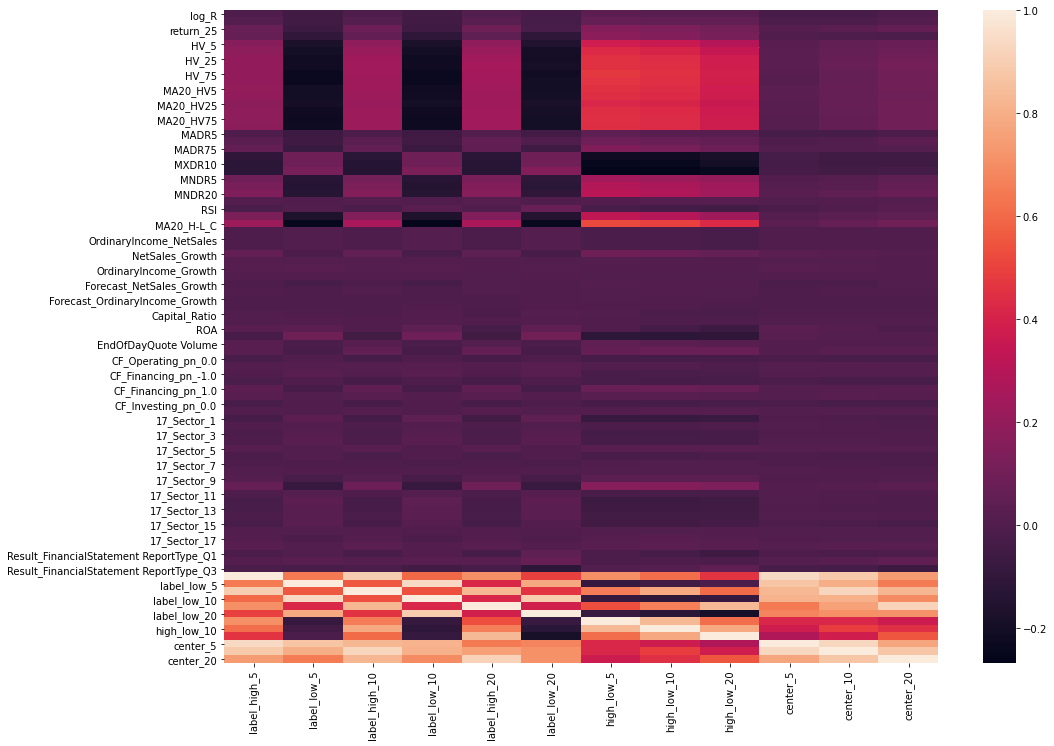

In [12]:
# 相関を見る
Y_cols = ['label_high_5', 'label_low_5', 'label_high_10', 'label_low_10', 'label_high_20', 'label_low_20', 
          'high_low_5', 'high_low_10', 'high_low_20', 'center_5', 'center_10', 'center_20']

plt.figure(figsize=(16, 12))
corr_mat = XY.drop(['Local Code'], axis=1).corr(method='pearson')
sns.heatmap(corr_mat.loc[:, Y_cols])

<メモ:追加した説明変数について>
* ボラティリティは期間が変わっても相関が強い
* ボラティリティの平均も相関が強い
* H-L_C(値幅)は相関がありそう
* CFのone-hotベクトル化により各特徴が表立ったかもしれない
* セクター情報も相関がある
* 決算種別も相関がみられる（特に本決算は最安値との相関がありそう)

In [13]:
XY.to_csv('../data/XY2.csv', index=False)

In [14]:
XY.describe()

,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_10,HV_25,HV_50,HV_75,HV_100,MA20_HV5,MA20_HV10,MA20_HV25,MA20_HV50,MA20_HV75,MA20_HV100,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,H-L_C,MA20_H-L_C,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,Dividend_Yeild,EndOfDayQuote Volume,CF_Operating_pn_-1.0,CF_Operating_pn_0.0,CF_Operating_pn_1.0,CF_Financing_pn_-1.0,CF_Financing_pn_0.0,CF_Financing_pn_1.0,CF_Investing_pn_-1.0,CF_Investing_pn_0.0,CF_Investing_pn_1.0,17_Sector_1,17_Sector_2,17_Sector_3,17_Sector_4,17_Sector_5,17_Sector_6,17_Sector_7,17_Sector_8,17_Sector_9,17_Sector_10,17_Sector_11,17_Sector_12,17_Sector_13,17_Sector_14,17_Sector_15,17_Sector_16,17_Sector_17,Result_FinancialStatement ReportType_Annual,Result_FinancialStatement ReportType_Q1,Result_FinancialStatement ReportType_Q2,Result_FinancialStatement ReportType_Q3,label_high_5,label_low_5,label_high_10,label_low_10,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
count,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,59551.000000,61317.000000,61416.000000,61440.000000,61440.000000,61440.000000,61440.000000,56251.000000,55155.000000,56164.000000,56868.000000,61440.000000,61437.000000,61437.000000,61433.000000,6.144000e+04,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.00000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61369.000000,61369.000000,61383.000000,61383.000000,61206.000000,61206.000000,61369.000000,61383.000000,61206.000000,61369.000000,61383.000000,61206.000000
mean,5775.247412,0.001975,0.005356,0.020869,0.041012,0.030450,0.029367,0.029492,0.030398,0.032055,0.032242,0.027987,0.028509,0.030155,0.031422,0.032180,0.032256,0.002445,0.009355,0.013351,-0.017102,-0.029452,-0.045463,0.020828,0.036260,0.059252,0.002311,0.527101,0.036517,0.025529,-0.075631,-0.070126,-0.094265,0.044735,0.012732,-0.027371,-0.008297,0.881523,0.613976,0.701371,0.827703,0.527788,0.018935,0.016093,0.010106,5.256519e+05,0.033708,0.764746,0.201546,0.166553,0.766227,0.067220,0.204867,0.765348,0.029785,0.038070,0.005013,0.083643,0.081201,0.018945,0.031185,0.022233,0.064893,0.084505,0.267122,0.006917,0.032357,0.086165,0.096566,0.02321,0.023161,0.034814,0.235449,0.262288,0.269417,0.232845,0.043464,-0.044682,0.060286,-0.055682,0.087256,-0.073195,0.088147,0.115968,0.160451,-0.000609,0.002302,0.007030
std,2391.023733,0.031771,0.058337,0.125621,0.246823,0.024182,0.020680,0.018045,0.017351,0.016682,0.016068,0.017218,0.017407,0.017781,0.017282,0.016542,0.016122,0.030650,0.066161,0.108572,0.028173,0.041819,0.057440,0.033271,0.054307,0.084773,0.051933,0.170109,0.031746,0.015595,6.021258,6.012463,5.991176,0.489204,10.137464,8.857976,19.662687,2.295970,22.868930,17.215569,21.746155,0.216180,2.190569,0.067115,0.012047,2.496761e+06,0.180477,0.424161,0.401158,0.372579,0.423233,0.250405,0.403607,0.423784,0.169996,0.191366,0.070626,0.276853,0.273146,0.136333,0.173819,0.147442,0.246338,0.278146,0.442460,0.082883,0.176947,0.280610,0.295368,0.15057,0.150415,0.183311,0.424283,0.439882,0.443661,0.422648,0.092168,0.065408,0.114546,0.072519,0.160839,0.090319,0.070638,0.097213,0.150942,0.07168

In [15]:
XY.isnull().sum()

base_date                                         0
Local Code                                        0
log_R                                             0
return_5                                          0
return_25                                         0
return_75                                         0
HV_5                                              0
HV_10                                             0
HV_25                                             0
HV_50                                             0
HV_75                                             0
HV_100                                            0
MA20_HV5                                          0
MA20_HV10                                         0
MA20_HV25                                         0
MA20_HV50                                         0
MA20_HV75                                         0
MA20_HV100                                        0
MADR5                                             0
MADR25      

In [16]:
# 欠損値はゼロ埋め
XY.fillna(0, inplace=True)
print('null num;', XY.isnull().sum().sum())

# 開始時点と終了時点
print('start:', XY.base_date.min(), ' end:', XY.base_date.max())

XY.describe()

null num; 0
start: 2016-06-29 00:00:00  end: 2020-12-29 00:00:00


,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_10,HV_25,HV_50,HV_75,HV_100,MA20_HV5,MA20_HV10,MA20_HV25,MA20_HV50,MA20_HV75,MA20_HV100,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,H-L_C,MA20_H-L_C,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,Dividend_Yeild,EndOfDayQuote Volume,CF_Operating_pn_-1.0,CF_Operating_pn_0.0,CF_Operating_pn_1.0,CF_Financing_pn_-1.0,CF_Financing_pn_0.0,CF_Financing_pn_1.0,CF_Investing_pn_-1.0,CF_Investing_pn_0.0,CF_Investing_pn_1.0,17_Sector_1,17_Sector_2,17_Sector_3,17_Sector_4,17_Sector_5,17_Sector_6,17_Sector_7,17_Sector_8,17_Sector_9,17_Sector_10,17_Sector_11,17_Sector_12,17_Sector_13,17_Sector_14,17_Sector_15,17_Sector_16,17_Sector_17,Result_FinancialStatement ReportType_Annual,Result_FinancialStatement ReportType_Q1,Result_FinancialStatement ReportType_Q2,Result_FinancialStatement ReportType_Q3,label_high_5,label_low_5,label_high_10,label_low_10,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
count,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,6.144000e+04,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.00000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000,61440.000000
mean,5775.247412,0.001975,0.005356,0.020869,0.041012,0.030450,0.029367,0.029492,0.030398,0.032055,0.032242,0.027987,0.028509,0.030155,0.031422,0.032180,0.032256,0.002445,0.009355,0.013351,-0.017102,-0.029452,-0.045463,0.020828,0.036260,0.059252,0.002311,0.527101,0.036517,0.025529,-0.073306,-0.069986,-0.094228,0.044735,0.012732,-0.027371,-0.008297,0.807073,0.551169,0.641143,0.766110,0.527788,0.018934,0.016092,0.010105,5.256519e+05,0.033708,0.764746,0.201546,0.166553,0.766227,0.067220,0.204867,0.765348,0.029785,0.038070,0.005013,0.083643,0.081201,0.018945,0.031185,0.022233,0.064893,0.084505,0.267122,0.006917,0.032357,0.086165,0.096566,0.02321,0.023161,0.034814,0.235449,0.262288,0.269417,0.232845,0.043414,-0.044631,0.060230,-0.055630,0.086923,-0.072916,0.088045,0.115861,0.159840,-0.000608,0.002300,0.007003
std,2391.023733,0.031771,0.058337,0.125621,0.246823,0.024182,0.020680,0.018045,0.017351,0.016682,0.016068,0.017218,0.017407,0.017781,0.017282,0.016542,0.016122,0.030650,0.066161,0.108572,0.028173,0.041819,0.057440,0.033271,0.054307,0.084773,0.051933,0.170109,0.031746,0.015595,5.927985,6.006443,5.990006,0.489204,10.137464,8.857976,19.662687,2.210509,21.668472,16.460969,20.922519,0.216180,2.190515,0.067114,0.012047,2.496761e+06,0.180477,0.424161,0.401158,0.372579,0.423233,0.250405,0.403607,0.423784,0.169996,0.191366,0.070626,0.276853,0.273146,0.136333,0.173819,0.147442,0.246338,0.278146,0.442460,0.082883,0.176947,0.280610,0.295368,0.15057,0.150415,0.183311,0.424283,0.439882,0.443661,0.422648,0.092126,0.065388,0.114508,0.072505,0.160622,0.090259,0.070661,0.097232,0.150978,0.07164

In [17]:
# データの分割期間の設定
TRAIN_END = "2017-11-30"
VAL_START = "2018-01-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

In [18]:
# 不要な列を削除
XY.drop(['Local Code', 'label_date_5', 'label_date_10', 'label_date_20'], axis=1, inplace=True)

# データを分割する
XY.set_index('base_date', inplace=True)
train_XY = XY.loc[:TRAIN_END]
val_XY = XY.loc[VAL_START:VAL_END]
test_XY = XY.loc[TEST_START:]

# 説明変数と目的変数を分ける
Y_cols = ['label_high_5', 'label_low_5', 'label_high_10', 'label_low_10', 'label_high_20', 'label_low_20', 
          'high_low_5', 'high_low_10', 'high_low_20', 'center_5', 'center_10', 'center_20']

train_X = train_XY.drop(Y_cols, axis=1).copy()
train_Y = train_XY.loc[:, Y_cols]
val_X = val_XY.drop(Y_cols, axis=1).copy()
val_Y = val_XY.loc[:, Y_cols]
test_X = test_XY.drop(Y_cols, axis=1).copy()
test_Y = test_XY.loc[:, Y_cols]

## モデル構築
前回の結果、スコアが高かったRandomForestとGradientBoostingに絞る

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, accuracy_score
from scipy.stats import spearmanr
import pickle, os

SEED = 0
np.random.seed(SEED)

# モデルの保存先
save_dir = '../models/ML2'

# モデルを定義
models = {
    'RandomForest':RandomForestRegressor(random_state=SEED),
    'GradientBoosting':GradientBoostingRegressor(random_state=SEED),
}

In [20]:
# 標準化処理
sc = StandardScaler()
sc.fit(train_X)
train_X = sc.transform(train_X)
val_X = sc.transform(val_X)
test_X = sc.transform(test_X)

In [27]:
test_X.shape

(28264, 75)

In [25]:
# 保存
with open('../models/ML2/SC.pickle', mode='wb') as fp:
    pickle.dump(sc, fp)

In [31]:
scores = {}
for model_name, model in models.items():
    for label in Y_cols:
        model.fit(train_X, train_Y[label])
        scores[(label, model_name, 'MSE')] = mean_squared_error(val_Y[label], model.predict(val_X))
        scores[(label, model_name, 'MAE')] = mean_absolute_error(val_Y[label], model.predict(val_X))
        scores[(label, model_name, 'MedAE')] = median_absolute_error(val_Y[label], model.predict(val_X))
        scores[(label, model_name, 'R2')] = r2_score(val_Y[label], model.predict(val_X))
        scores[(label, model_name, 'Accuracy')] = accuracy_score(np.sign(val_Y[label]), np.sign(model.predict(val_X)))
        scores[(label, model_name, 'Corr')] = np.corrcoef(val_Y[label], model.predict(val_X))[0, 1]
        scores[(label, model_name, 'SpearmanCorr')] = spearmanr(val_Y[label], model.predict(val_X))[0]
        
        # save model
        save_model_name = model_name + '_' + label + '.pickle'
        save_path = os.path.join(save_dir, save_model_name)
        with open(save_path, mode='wb') as fp:
            pickle.dump(model, fp)

In [32]:
result = pd.Series(scores).unstack()
result.to_csv('../result/ML_val_result2.csv')
result

Accuracy      Corr       MAE       MSE  \
center_10     GradientBoosting  0.526833  0.188442  0.056573  0.006697   
              RandomForest      0.539293  0.236651  0.056856  0.006654   
center_20     GradientBoosting  0.474218  0.145943  0.067806  0.009532   
              RandomForest      0.496059  0.200313  0.068790  0.009590   
center_5      GradientBoosting  0.566239  0.223574  0.050042  0.005357   
              RandomForest      0.572243  0.257592  0.050068  0.005285   
high_low_10   GradientBoosting  0.999625  0.552247  0.042994  0.005014   
              RandomForest      0.999625  0.553855  0.044476  0.005013   
high_low_20   GradientBoosting  1.000000  0.510872  0.055428  0.010038   
              RandomForest      1.000000  0.496814  0.059687  0.010661   
high_low_5    GradientBoosting  0.998649  0.605332  0.033737  0.002884   
              RandomForest      0.998649  0.578035  0.034943  0.002966   
label_high_10 GradientBoosting  0.734744  0.294172  0.066728  0.010337   
              RandomForest      0.736095  0.312659  0.068848  0.010523   
label_high_20 GradientBoosting  0.777678  0.278383  0.084444  0.017326   
              RandomForest      0.777753  0.286996  0.089223  0.018453   
label_high_5  GradientBoosting  0.697966  0.307376  0.056552  0.007413   
              RandomForest      0.701193  0.319229  0.057578  0.007422   
label_low_10  GradientBoosting  0.850934  0.321160  0.053488  0.005650   
              RandomForest      0.850634  0.314381  0.053427  0.005614   
label_low_20  GradientBoosting  0.887263  0.357176  0.059092  0.006715   
              RandomForest      0.886587  0.333402  0.059139  0.006728   
label_low_5   GradientBoosting  0.816258  0.308837  0.049070  0.004854   
              RandomForest      0.815807  0.305436  0.049037  0.004829   

                                   MedAE        R2  SpearmanCorr  
center_10     GradientBoosting  0.038863  0.003253      0.196816  
              RandomForest      0.039773  0.009542      0.215587  
center_20     GradientBoosting  0.048743 -0.068801      0.153070  
              RandomForest      0.049617 -0.075289      0.192035  
center_5      GradientBoosting  0.033741  0.038047      0.217830  
              RandomForest      0.034175  0.050997      0.235245  
high_low_10   GradientBoosting  0.028636  0.292224      0.648908  
              RandomForest      0.029925  0.292249      0.627060  
high_low_20   GradientBoosting  0.036215  0.245206      0.665159  
              RandomForest      0.038156  0.198416      0.631924  
high_low_5    GradientBoosting  0.022742  0.343972      0.652418  
              RandomForest      0.024241  0.325343      0.626841  
label_high_10 GradientBoosting  0.044632  0.067129      0.284534  
              RandomForest      0.047183  0.050306      0.299659  
label_high_20 GradientBoosting  0.058989  0.017681      0.284357  
              RandomForest      0.062423 -0.046210      0.301442  
label_high_5  GradientBoosting  0.037242  0.092576      0.286501  
              RandomForest      0.038548  0.091488      0.295322  
label_low_10  GradientBoosting  0.037126  0.042104      0.329672  
              RandomForest      0.037261  0.048139      0.317357  
label_low_20  GradientBoosting  0.042448  0.019543      0.361816  
              RandomForest      0.042040  0.017599      0.340308  
label_low_5   GradientBoosting  0.033319  0.060427      0.318803  
              RandomForest      0.033819  0.065282      0.310188

In [33]:
# テストデータ
scores_test = {}
for model_name, _ in models.items():
    for label in Y_cols:
        # load model
        load_model_name = model_name + '_' + label + '.pickle'
        load_path = os.path.join(save_dir, load_model_name)
        with open(load_path, mode='rb') as fp:
            model = pickle.load(fp)
        
        # predict test 
        scores_test[(label, model_name, 'MSE')] = mean_squared_error(test_Y[label], model.predict(test_X))
        scores_test[(label, model_name, 'MAE')] = mean_absolute_error(test_Y[label], model.predict(test_X))
        scores_test[(label, model_name, 'MedAE')] = median_absolute_error(test_Y[label], model.predict(test_X))
        scores_test[(label, model_name, 'R2')] = r2_score(test_Y[label], model.predict(test_X))
        scores_test[(label, model_name, 'Accuracy')] = accuracy_score(np.sign(test_Y[label]), np.sign(model.predict(test_X)))
        scores_test[(label, model_name, 'Corr')] = np.corrcoef(test_Y[label], model.predict(test_X))[0, 1]
        scores_test[(label, model_name, 'SpearmanCorr')] = spearmanr(test_Y[label], model.predict(test_X))[0]

result_test = pd.Series(scores_test).unstack()
result_test.to_csv('../result/ML_test_result2.csv')
result_test

Accuracy      Corr       MAE       MSE  \
center_10     GradientBoosting  0.522078  0.095765  0.056718  0.007576   
              RandomForest      0.523705  0.141494  0.057844  0.007518   
center_20     GradientBoosting  0.508491  0.097721  0.074684  0.013397   
              RandomForest      0.512029  0.125392  0.076835  0.013620   
center_5      GradientBoosting  0.546879  0.138725  0.047814  0.005507   
              RandomForest      0.546384  0.183378  0.048491  0.005479   
high_low_10   GradientBoosting  0.997806  0.450534  0.051409  0.008666   
              RandomForest      0.997806  0.475699  0.053287  0.008233   
high_low_20   GradientBoosting  0.991686  0.366727  0.082436  0.022862   
              RandomForest      0.991686  0.370759  0.086853  0.023059   
high_low_5    GradientBoosting  0.997311  0.534387  0.035634  0.004041   
              RandomForest      0.997311  0.501994  0.037608  0.004294   
label_high_10 GradientBoosting  0.779331  0.234165  0.069721  0.013902   
              RandomForest      0.779826  0.247181  0.072293  0.014055   
label_high_20 GradientBoosting  0.815454  0.216065  0.092921  0.028114   
              RandomForest      0.815525  0.253178  0.097822  0.027743   
label_high_5  GradientBoosting  0.734185  0.226737  0.056757  0.009198   
              RandomForest      0.734892  0.240716  0.058286  0.009181   
label_low_10  GradientBoosting  0.838452  0.240159  0.051892  0.005515   
              RandomForest      0.838346  0.225762  0.052511  0.005586   
label_low_20  GradientBoosting  0.861449  0.137216  0.070040  0.011389   
              RandomForest      0.861343  0.127109  0.070434  0.011416   
label_low_5   GradientBoosting  0.808060  0.271602  0.044856  0.004118   
              RandomForest      0.808201  0.252043  0.045516  0.004215   

                                   MedAE        R2  SpearmanCorr  
center_10     GradientBoosting  0.037576 -0.028412      0.105016  
              RandomForest      0.038949 -0.020632      0.112296  
center_20     GradientBoosting  0.049502 -0.051969      0.104069  
              RandomForest      0.051557 -0.069466      0.105875  
center_5      GradientBoosting  0.031005  0.008761      0.148125  
              RandomForest      0.032001  0.013701      0.153832  
high_low_10   GradientBoosting  0.033010  0.155315      0.612559  
              RandomForest      0.035681  0.197458      0.587044  
high_low_20   GradientBoosting  0.051510  0.094778      0.513400  
              RandomForest      0.055307  0.086989      0.489770  
high_low_5    GradientBoosting  0.023735  0.283863      0.651351  
              RandomForest      0.025530  0.238960      0.628551  
label_high_10 GradientBoosting  0.044358  0.013085      0.267444  
              RandomForest      0.047534  0.002201      0.259151  
label_high_20 GradientBoosting  0.060446 -0.033702      0.295687  
              RandomForest      0.064819 -0.020057      0.286386  
label_high_5  GradientBoosting  0.035138  0.032669      0.253332  
              RandomForest      0.037495  0.034500      0.241584  
label_low_10  GradientBoosting  0.035779  0.045156      0.240623  
              RandomForest      0.036490  0.032981      0.227163  
label_low_20  GradientBoosting  0.043066 -0.044722      0.160868  
              RandomForest      0.043885 -0.047218      0.154893  
label_low_5   GradientBoosting  0.031238  0.068888      0.277072  
              RandomForest      0.032083  0.047126      0.261630

<メモ>  
前回より全体的に精度向上  


【SpearmanCorr】  
* label_high_20  
  * GradientBoosting: 0.284255758 ⇒ 0.295687
  * RandomForest: 0.274139051 ⇒ 0.286386

* label_low_20
  * GradientBoosting:0.144091995 ⇒ 0.160868  
  * RandomForest: 0.145896255 ⇒ 0.154893  


## 説明変数の重要度

Text(0.5, 1.0, 'label_low_20')

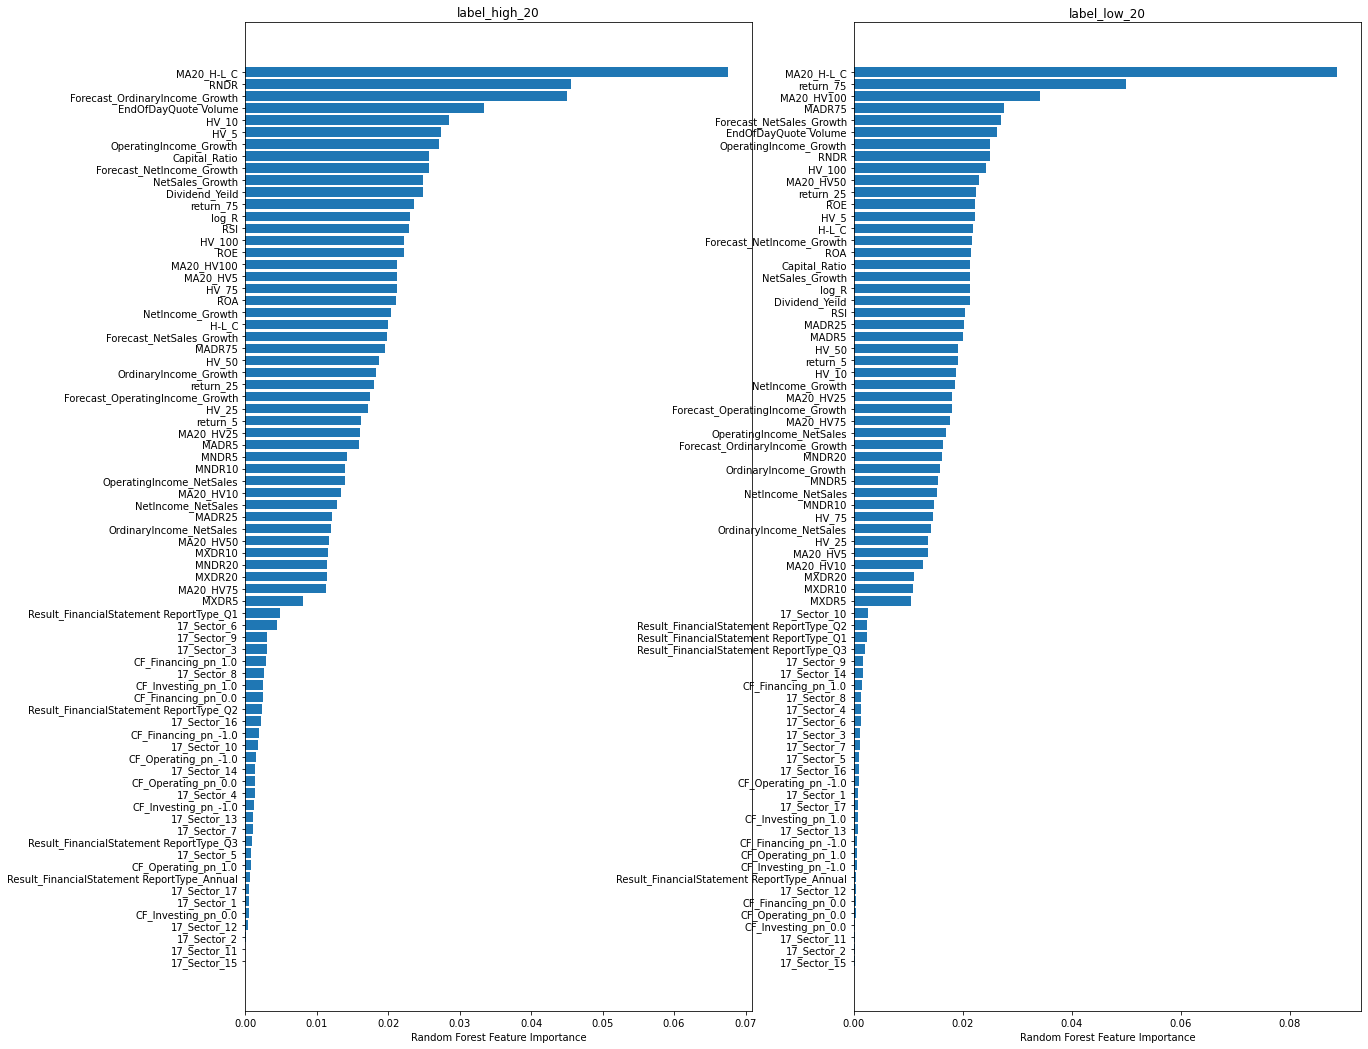

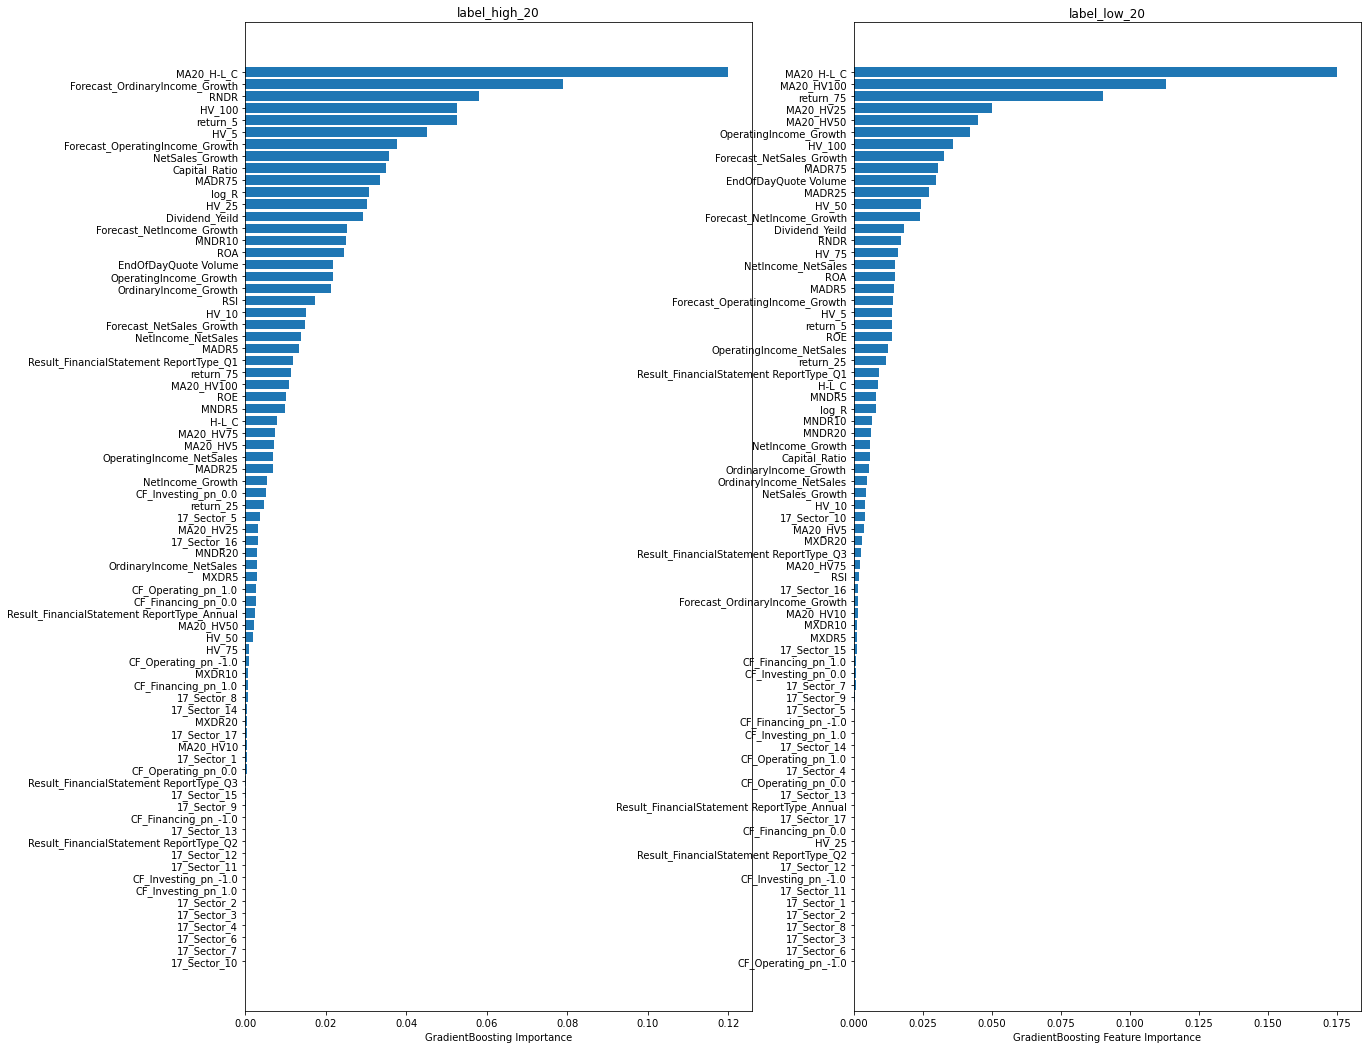

In [36]:
# 学習済みモデルを指定
save_path = os.path.join(save_dir, 'RandomForest_label_high_20.pickle')
with open(save_path, mode='rb') as fp:
    rf = pickle.load(fp)

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(2, 2, 1)
ax.barh(train_XY.columns.drop(Y_cols)[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")
plt.title('label_high_20')

# 学習済みモデルを指定
save_path = os.path.join(save_dir, 'RandomForest_label_low_20.pickle')
with open(save_path, mode='rb') as fp:
    rf = pickle.load(fp)

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
ax = fig.add_subplot(2, 2, 2)
ax.barh(train_XY.columns.drop(Y_cols)[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")
plt.title('label_low_20')

# 学習済みモデルを指定
save_path = os.path.join(save_dir, 'GradientBoosting_label_high_20.pickle')
with open(save_path, mode='rb') as fp:
    rf = pickle.load(fp)

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(2, 2, 3)
ax.barh(train_XY.columns.drop(Y_cols)[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("GradientBoosting Importance")
plt.title('label_high_20')

# 学習済みモデルを指定
save_path = os.path.join(save_dir, 'GradientBoosting_label_low_20.pickle')
with open(save_path, mode='rb') as fp:
    rf = pickle.load(fp)

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
ax = fig.add_subplot(2, 2, 4)
ax.barh(train_XY.columns.drop(Y_cols)[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("GradientBoosting Feature Importance")
plt.title('label_low_20')

<メモ>  
* 今回作成した値幅に関する変数(H-L_C)がかなり有効
* 出来高も昨日している
* カテゴリ変数は意味がないように思われる  
  ⇒削除してみる